In [ ]:
# !pip install casadi
# !pip install control

In [2]:
from __future__ import annotations        # can be used in Python 3.7 or higher
import numpy as np
import casadi as ca
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3D
import matplotlib.animation as animation
import sys
sys.path.insert(0,'../test_system/quadrotor/controlled_u')
import params as par
import control

In [3]:
def thrust(throttle, rho, r, V, kV, CT, Cm):
    """
    throttle: 0-1 controls voltage
    rho: density of air, [kg/m^3]
    r: radius of propeller, [m]
    V: voltage of battery [V]
    kV: motor kV constant, [rpm/V]
    """
    omega = throttle*V*kV*(2*ca.pi/60)
    q = 0.5*rho*(omega*r)**2
    s = ca.pi*r**2

    return CT*q*s,Cm*q*s


def throttle(force, rho, r, V, kV, CT, Cm):
    s = ca.pi*r**2
    q = 0.25*force / (s * CT)
    omega = ((2*q/rho)**0.5)*(1/r)

    return (omega/(V*kV))*(60/(2*ca.pi))

# def euler_kinematics(e, w):
#     '''Derivative of Euler angles'''
#     v = ca.SX.sym('v',3)
#     v[2] = (w[1]*ca.sin(e[2])+w[2]*ca.cos(e[2]))/ca.cos(e[1])
#     v[1] = w[1]*ca.cos(e[2]) - w[2]*ca.sin(e[2])
#     v[0] = w[0] + (w[1]*ca.sin(e[2]+w[2]*ca.cos(e[2])))*ca.tan(e[1])
#     return v

def euler_kinematics(e, w):
    '''Derivative of Euler angles'''
    v = ca.SX.sym('v',3)
    v[0] = w[0] - w[2]*ca.sin(e[1])
    v[1] = w[1]*ca.cos(e[0]) + w[2]*ca.cos(e[1])*ca.sin(e[0])
    v[2] = w[2]*ca.cos(e[1])*ca.cos(e[0]) - w[1]*ca.sin(e[0])
    return v

def rk4(f, t, y, h):
    """Runge Kuta 4th order integrator"""
    k1 = h * f(t, y)
    k2 = h * f(t + h / 2, y + k1 / 2)
    k3 = h * f(t + h / 2, y + k2 / 2)
    k4 = h * f(t + h, y + k3)
    return ca.simplify(y + (k1 + 2 * k2 + 2 * k3 + k4) / 6)

def euler_to_dcm(e):
    ''' Transition from Euler angles to direction cosine matrix'''
    phi = e[0]
    theta = e[1]
    psi = e[2]
    R_z = np.array([
        [ca.cos(psi), -ca.sin(psi), 0],
        [ca.sin(psi), ca.cos(psi), 0],
        [0, 0, 1]
    ])
    R_y = np.array([
        [ca.cos(theta), 0, ca.sin(theta)],
        [0, 1, 0],
        [-ca.sin(theta), 0, ca.cos(theta)]
    ])
    R_x = np.array([
        [1, 0, 0],
        [0, ca.cos(phi), -ca.sin(phi)],
        [0, ca.sin(phi), ca.cos(phi)]
    ])

    # R = np.dot(np.dot(R_z, R_y), R_x)
    R = np.dot(R_x,np.dot(R_y, R_z))
    
    return R

def motor2mix(u_motor):
    '''from each motor duty to effect toward control angles'''
    map = np.array([
        [1,-1,-1,1],
        [-1,1,-1,1],
        [-1,-1,1,1],
        [1,1,1,1]])
    return ca.mtimes(map,u_motor)

def mix2motor(u_mix):
    '''from input of control to each motor duty'''
    map = np.linalg.inv(np.array([
        [1,-1,-1,1],
        [-1,1,-1,1],
        [-1,-1,1,1],
        [1,1,1,1]]))
    return ca.mtimes(map,u_mix)

def saturate(motor: ca.SX, len: int) -> ca.SX:
    ''' saturate the input motor voltage '''
    for i in range(4):
        temp = motor[i]
        temp = ca.if_else(temp > 1, 1,
                          ca.if_else(temp < 0, 0, temp))
        motor[i] = temp
    return motor

def update_lines(num, data, line):
    # NOTE: there is no .set_data() for 3 dim data...
    line.set_data(data[0:2, :num])
    line.set_3d_properties(data[2, :num])
    return line

In [4]:
def derive_equations():
    # Parameters & rotorcraft data
    arm_angles_deg = [45, -135, -45, 135]
    arm_angles_rad = [
        (np.pi / 180) * i for i in arm_angles_deg
    ]
    motor_dirs = [1, 1, -1, -1]             # motor rotation direction

    # state (x)
    x = ca.SX.sym('x',12)
    omega_b = x[0:3]                      # Angular velocity (body)
    vel_b = x[3:6]                        # Velocity (body)
    euler = x[6:9]                        # Orientation (inertial) = r_nb
    pos_n = x[9:12]                       # Position (inertial)

    # reference position
    pos_n_ref = ca.SX.sym('pos_n_ref',3)

    # input
    n_motors = len(arm_angles_deg)
    u_mix = ca.SX.sym('u_mix', 4)           # roll, pitch, yaw, throttle [V]

    # parameters
    p = ca.SX.sym('p', 12)
    m = p[0]                # mass of the body [kg]
    l_arm = p[1]            # length or the rotor arm [m]
    r = p[2]                # radius of propeller [m]
    rho = p[3]              # density of air [kg/m^3]
    V = p[4]                # voltage of battery [V]
    kV = p[5]               # motor kV constant, [rpm/V]
    CT = p[6]               # Thrust coeff
    Cm = p[7]               # moment coeff
    g = p[8]                # gravitational constant [m/s^2]
    Jx = p[9]
    Jy = p[10]
    Jz = p[11]


    J_b = ca.diag(ca.vertcat(Jx, Jy, Jz))                                             # Moment of inertia of quadrotor

    # forces and moments
    C_nb = euler_to_dcm(euler)                                                      # from euler to direction cosine matrix
    F_b = ca.vertcat(0, 0, 0)
    g_b = ca.mtimes(C_nb.T, ca.vertcat(0, 0, -m*g))
    F_b += g_b                                                                      # Body Force Initialize  
    M_b = ca.SX.zeros(3)                                                            # Body moment(torque) Initialize
    u_motor = saturate(mix2motor(u_mix), len(motor_dirs))                           # convert u_mix(angle input) to motor duty

    for i in range(n_motors):
        ri_b = ca.vertcat(
            l_arm*ca.cos(arm_angles_rad[i]),
            l_arm*ca.sin(arm_angles_rad[i]), 
            0
        )                                                                           # vector to each motor from center
        Fi_b, Mi_b = thrust(
            throttle = u_motor[i], rho = rho, r = r,
            V = V, kV = kV, CT = CT, Cm = Cm                                        # get scalar F and M of each rotor
        )                                     
        Fi_b_vec = ca.vertcat(0, 0, Fi_b)
        Mi_b_vec = ca.vertcat(0, 0, -motor_dirs[i] * Mi_b)                           # get each rotor's F and M vector
        F_b += Fi_b_vec                                                             # sum up all rotor F vector
        M_b += Mi_b_vec + ca.cross(ri_b, Fi_b_vec)                                  # sum up all rotor M vector & M from each leg

    force_moment = ca.Function('force_moment',[x,u_mix,p],[F_b,M_b],['x','u_mix','p'],['F_b','M_b'])

    rhs = ca.Function('rhs',[x,u_mix,p],[ca.vertcat(
        ca.mtimes(ca.inv(J_b),
                  M_b - ca.cross(omega_b, ca.mtimes(J_b, omega_b))),                # omega dot (angular acceleration)
        F_b/m - ca.cross(omega_b,vel_b),                                            # v dot (acceleration)
        euler_kinematics(euler,omega_b),                                            # omega (angular velocity) (inertial)
        ca.mtimes(C_nb, vel_b),                                                   # v (velocity) (inertial)
        )], ['x','u_mix','p'],['x_dot'])

    vel_ref = pos_n_ref - pos_n
    vel_ref_b = ca.mtimes(C_nb.T, vel_ref)
    acc_ref_b = vel_ref_b - vel_b
    # vel_err_b_z = acc_ref_b[2]
    F_ref_b = acc_ref_b * par.m
    F_ref_T_b = F_ref_b - g_b
    vel_err_z_b = F_ref_T_b[2] / par.m

    F_ref_b[2] = 0
    F_Tf_b = F_ref_b - g_b
    F_b_xy = F_b
    F_b_xy[2] = 0
    F_Ti_b = F_b_xy - g_b
    theta_err_b_mag = ca.acos(ca.dot(F_Tf_b, F_Ti_b) / (ca.norm_1(F_Tf_b)*ca.norm_1(F_Ti_b)))
    theta_err_b_hat = ca.cross(F_Ti_b, F_Tf_b) / ca.norm_1(ca.cross(F_Ti_b, F_Tf_b))
    omega_b_ref = theta_err_b_hat * theta_err_b_mag
    omega_b_err = omega_b_ref - omega_b
    
    f_control = ca.Function('f_control', [x,u_mix,p,pos_n_ref], [vel_err_z_b, omega_b_err, vel_ref_b, omega_b_ref],
    ['x','u_mix','p','pos_n_ref'],['vel_err_z_b','omega_b_err','vel_ref_b','omega_b_ref'])    

    return {
        'x': x,
        'u_mix': u_mix,
        'p': p,
        'force_moment': force_moment,
        'rhs': rhs,
        'f_control': f_control
    }

In [5]:
def linearize(eqs):
    x = eqs['x']
    u_mix = eqs['u_mix']
    p = eqs['p']
    y = x  # state feedback
    rhs = eqs['rhs']
    xdot = rhs(x, u_mix, p)
    A = ca.jacobian(xdot, x)
    B = ca.jacobian(xdot, u_mix)
    C = ca.jacobian(y, x)
    D = ca.jacobian(y, u_mix)
    return ca.Function('ss', [x, u_mix, p], [A, B, C, D],
            ['x', 'u', 'p'], ['A', 'B', 'C', 'D'])

[-0.11271124 -0.03757041  0.          1.44388352]


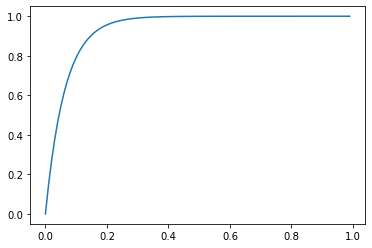

In [13]:
eqs = derive_equations()
lin_state_func = linearize(eqs)
xi = [0]*12
xi[9:12] = par.startpoint
p = par.p
dt = 0.01
t = 0.1
hover_thrust = throttle(p[0]*p[8],p[3],p[2],p[4],p[5],p[6],p[7])
# hover_thrust = 0.1
u0 = np.array([0,0,0,hover_thrust*4])
ui = u0
xi_c = np.zeros(1)
xi_c2 = np.zeros([2,1])

[err_vbz, err_wb, ref_vb, ref_wb] = eqs['f_control'](xi, ui, p, par.ref_trajectory[int(t/dt)])
err_vbz *= 1

[A,B,C,D] = lin_state_func(xi,ui,p)
sys = control.ss(A,B,C,D)
tf_sys = control.ss2tf(sys).minreal(tol=1e-6)
rollr_tf = tf_sys[0,0]
pitchr_tf = tf_sys[1,1]
yawr_tf = tf_sys[2,2]
thrust_tf = tf_sys[5,3]

TF = [rollr_tf, pitchr_tf, yawr_tf, thrust_tf]
TF_f = TF

s = control.tf([1,0],[0,1])

H_com = 1
H_rollr = H_com
H_pitchr = H_com
H_yawr = 1
# H_thrustr = 3 + (s+10)/(s+5)
H_thrustr = 2

H = [H_rollr, H_pitchr, H_yawr, H_thrustr]

for i in range(len(TF)):
        TF[i] *= H[i]
        TF_f[i] = TF[i].feedback()

rollr_sys = control.tf2ss(control.c2d(TF_f[0], dt))
pitchr_sys = control.tf2ss(control.c2d(TF_f[1], dt))
yawr_sys = control.tf2ss(control.c2d(TF_f[2], dt))
thrust_sys = control.tf2ss(control.c2d(TF_f[3], dt))

rx_0 = np.zeros((rollr_sys.A.shape[0],1))
px_0 = np.zeros((pitchr_sys.A.shape[0],1))
yx_0 = np.zeros((yawr_sys.A.shape[0],1))
tx_0 = np.zeros((thrust_sys.A.shape[0],1))

rx = np.dot(rollr_sys.A, rx_0) + np.dot(rollr_sys.B, err_wb[0])
px = np.dot(pitchr_sys.A, px_0) + np.dot(pitchr_sys.B, err_wb[1])
yx = np.dot(yawr_sys.A, yx_0) + np.dot(yawr_sys.B, err_wb[2])
tx = np.dot(thrust_sys.A, tx_0) + np.dot(thrust_sys.B, err_vbz)

ui[0] = np.dot(rollr_sys.C, rx) + np.dot(rollr_sys.D, err_wb[0])
ui[1] = np.dot(pitchr_sys.C, px) + np.dot(pitchr_sys.D, err_wb[1])
ui[2] = np.dot(yawr_sys.C, yx) + np.dot(yawr_sys.D, err_wb[2])
ui[3] = np.dot(thrust_sys.C, tx) + np.dot(thrust_sys.D, err_vbz)
print(ui)
t,y = control.step_response(TF[3],np.arange(0,1,0.01))
plt.plot(t,y)

In [12]:
# tf_sys
# control.rlocus(TF[3]);
TF

[
   105.4
 ---------
 s + 105.4,
 
   105.4
 ---------
 s + 105.4,
 
   1.864
 ---------
 s + 1.864,
 
   15.66
 ---------
 s + 15.66]

In [25]:
def simulate(eqs: dict, dt: float, u0: np.array, p: list) -> dict:
    lin_state_func = linearize(eqs)
    t_vect = par.time
    # t_vect = np.arange(0,15,dt)
    xi = [0]*12
    xi[9:12] = par.startpoint
    ui = u0
    index = 0

    data = {
        't': np.zeros(t_vect.size),
        'x': np.zeros([t_vect.size,12]),
        'u': np.zeros([t_vect.size,4]),
        'dist': np.zeros([t_vect.size,3])
    }

    [A,B,C,D] = lin_state_func(xi,ui,p)
    sys = control.ss(A,B,C,D)
    tf_sys = control.ss2tf(sys).minreal(tol=1e-6)
    rollr_tf = tf_sys[0,0]
    pitchr_tf = tf_sys[1,1]
    yawr_tf = tf_sys[2,2]
    thrust_tf = tf_sys[5,3]

    TF = [rollr_tf, pitchr_tf, yawr_tf, thrust_tf]
   
    s = control.tf([1,0],[0,1])

    H_rollr = 2
    H_pitchr = 2
    H_yawr = 5
    H_thrustr = 4

    H = [H_rollr, H_pitchr, H_yawr, H_thrustr]

    for i in range(len(TF)):
        TF[i] *= H[i]
        TF[i] = TF[i].feedback()
    
    rollr_sys = control.tf2ss(control.c2d(TF[0], dt))
    pitchr_sys = control.tf2ss(control.c2d(TF[1], dt))
    yawr_sys = control.tf2ss(control.c2d(TF[2], dt))
    thrust_sys = control.tf2ss(control.c2d(TF[3], dt))

    rx_0 = np.zeros((rollr_sys.A.shape[0],1))
    px_0 = np.zeros((pitchr_sys.A.shape[0],1))
    yx_0 = np.zeros((yawr_sys.A.shape[0],1))
    tx_0 = np.zeros((thrust_sys.A.shape[0],1))

    for t in t_vect:
        [err_vbz, err_wb, ref_vbz, ref_wb] = eqs['f_control'](xi, ui, p, par.ref_trajectory[int(t/dt)]+1e-6)
        err_wb *= 1
        err_vbz *= 1
        
        # In-loop linearization
        # [A,B,C,D] = lin_state_func(xi,ui,p)
        # sys = control.ss(A,B,C,D)
        # tf_sys = control.ss2tf(sys).minreal(tol=1e-6)
        # rollr_tf = tf_sys[0,0]
        # pitchr_tf = tf_sys[1,1]
        # yawr_tf = tf_sys[2,2]
        # thrust_tf = tf_sys[5,3]

        # TF = [rollr_tf, pitchr_tf, yawr_tf, thrust_tf]

        # s = control.tf([1,0],[0,1])

        # H_com = 1
        # H_rollr = H_com
        # H_pitchr = H_com
        # H_yawr = 5
        # H_thrustr = 3+(s+10)/(s+8)

        # H = [H_rollr, H_pitchr, H_yawr, H_thrustr]

        # for i in range(len(TF)):
        #     TF[i] *= H[i]
        #     TF[i] = TF[i].feedback()
        
        # rollr_sys = control.tf2ss(control.c2d(TF[0], dt))
        # pitchr_sys = control.tf2ss(control.c2d(TF[1], dt))
        # yawr_sys = control.tf2ss(control.c2d(TF[2], dt))
        # thrust_sys = control.tf2ss(control.c2d(TF[3], dt))

        # rx_0 = np.zeros((rollr_sys.A.shape[0],1))
        # px_0 = np.zeros((pitchr_sys.A.shape[0],1))
        # yx_0 = np.zeros((yawr_sys.A.shape[0],1))
        # tx_0 = np.zeros((thrust_sys.A.shape[0],1))

        # Input calc
        rx = np.dot(rollr_sys.A, rx_0) + np.dot(rollr_sys.B, err_wb[0])
        px = np.dot(pitchr_sys.A, px_0) + np.dot(pitchr_sys.B, err_wb[1])
        yx = np.dot(yawr_sys.A, yx_0) + np.dot(yawr_sys.B, err_wb[2])
        tx = np.dot(thrust_sys.A, tx_0) + np.dot(thrust_sys.B, err_vbz)

        ui[0] = np.dot(rollr_sys.C, rx) + np.dot(rollr_sys.D, err_wb[0])
        ui[1] = np.dot(pitchr_sys.C, px) + np.dot(pitchr_sys.D, err_wb[1])
        ui[2] = np.dot(yawr_sys.C, yx) + np.dot(yawr_sys.D, err_wb[2])
        ui[3] = np.dot(thrust_sys.C, tx) + np.dot(thrust_sys.D, err_vbz)

        # rx_0 = rx
        # px_0 = px
        # yx_0 = yx
        # tx_0 = tx

        # ui = np.array([0.005,0.00,0,2.8])
        print(ui)

        data['x'][index] = xi
        data['u'][index] = ui
        data['t'][index] = t
        data['dist'][index] = par.ref_trajectory[int(t/dt)] - xi[9:12]
        
        res = scipy.integrate.solve_ivp(
            fun=lambda t, x: np.array(eqs['rhs'](xi, ui, p)).reshape(-1),
             t_span=[t, t+dt], t_eval=[t+dt], y0=xi
        )
        
        xi_new = res['y']
        if xi_new[11] <= 0:
            xi_new[11] = 0
        xi = np.array(xi_new).reshape(-1)

        index += 1

    for k in data.keys():
        data[k] = np.array(data[k])
    return data

In [26]:
model = derive_equations()
dt = 0.01
hover_thrust = throttle(p[0]*p[8],p[3],p[2],p[4],p[5],p[6],p[7])
u0 = np.array([0,0,0,hover_thrust*4])

data = simulate(model, dt, u0, par.p)

]
[ 3.96544232e-04  4.63558233e-03 -4.01647803e-06  2.50616984e+00]
[-1.63561329e-03  1.61177991e-02 -4.01103410e-06  2.50617078e+00]
[-3.18129125e-03  8.06381626e-03 -3.98694008e-06  2.50617071e+00]
[-4.17185993e-04 -2.33985273e-03 -3.96335522e-06  2.50617153e+00]
[ 4.66577666e-03 -1.58179669e-02 -3.95742898e-06  2.50617267e+00]
[-3.99650218e-04 -9.90822563e-03 -3.90203456e-06  2.50617268e+00]
[-8.25478033e-04  1.04128075e-03 -3.89818417e-06  2.50617353e+00]
[ 2.70254839e-04  1.51446298e-02 -3.89115139e-06  2.50617482e+00]
[-2.86856334e-03  1.05954742e-02 -3.88740709e-06  2.50617514e+00]
[-1.04310019e-03  2.44936716e-05 -3.86085073e-06  2.50617600e+00]
[ 4.53896885e-03 -1.17630675e-02 -3.85443168e-06  2.50617740e+00]
[-5.73286068e-04 -1.37983811e-02 -3.81271300e-06  2.50617812e+00]
[-1.76001091e-03 -2.52289192e-03 -3.81162464e-06  2.50617877e+00]
[ 1.57411603e-03  1.00512115e-02 -3.80824206e-06  2.50618025e+00]
[-2.50477650e-03  1.60784300e-02 -3.81239569e-06  2.50618132e+00]
[-1.6562

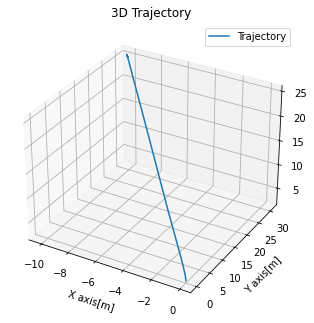

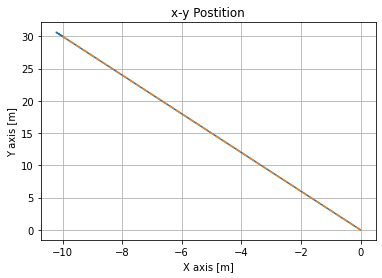

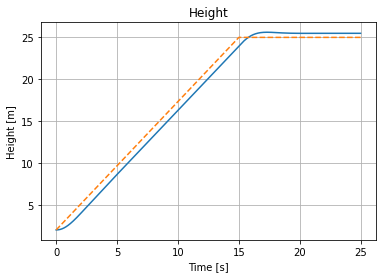

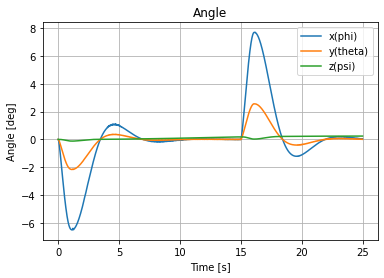

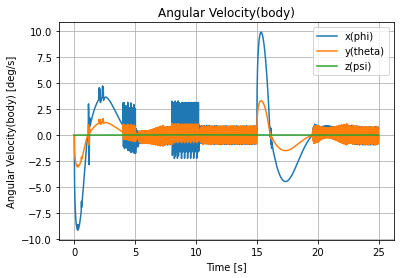

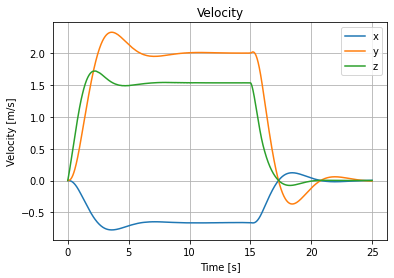

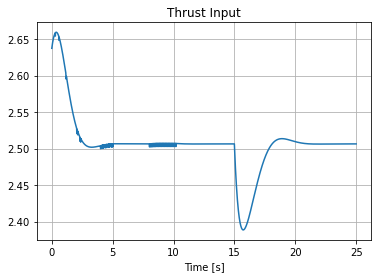

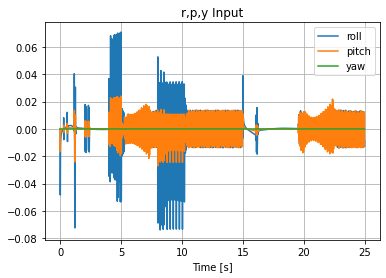

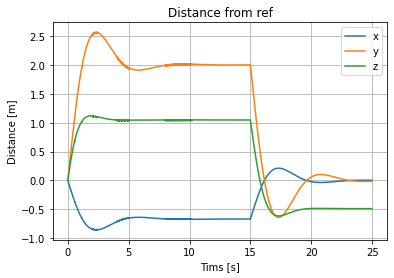

In [27]:
index_step = data['t'].size
# index_step = 1500
fig1 = plt.figure(1)
ax = Axes3D(fig1)
# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-10,10)
# ax.set_zlim3d(0,100)
plt.plot(data['x'][:index_step,9],
            data['x'][:index_step,10],
            data['x'][:index_step,11])
plt.title('3D Trajectory')
plt.xlabel('X axis[m]')
plt.ylabel('Y axis[m]')
plt.legend(['Trajectory'])
plt.grid()

fig2 = plt.figure(2)
plt.plot(data['x'][:index_step,9],
            data['x'][:index_step,10],
            par.ref_trajectory[:index_step,0],
            par.ref_trajectory[:index_step,1],'--')
plt.title('x-y Postition')
plt.xlabel('X axis [m]')
plt.ylabel('Y axis [m]')
plt.grid()

fig3 = plt.figure(3)
plt.plot(data['t'][:index_step],data['x'][:index_step,11],
        data['t'][:index_step],par.ref_trajectory[:index_step,2],'--')
plt.title('Height')
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.grid()

fig3 = plt.figure(4)
plt.plot(data['t'][:index_step], data['x'][:index_step,6]*180/ca.pi,
            data['t'][:index_step], data['x'][:index_step,7]*180/ca.pi,
            data['t'][:index_step], data['x'][:index_step,8]*180/ca.pi)
plt.title('Angle')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.legend(['x(phi)','y(theta)','z(psi)'])
plt.grid()

plt.figure(5)
plt.plot(data['t'][:index_step], data['x'][:index_step,0]*180/ca.pi,
            data['t'][:index_step], data['x'][:index_step,1]*180/ca.pi,
            data['t'][:index_step], data['x'][:index_step,2]*180/ca.pi)
plt.title('Angular Velocity(body)')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity(body) [deg/s]')
plt.legend(['x(phi)','y(theta)','z(psi)'])
plt.grid()

plt.figure(6)
plt.plot(data['t'][:index_step], data['x'][:index_step,3],
            data['t'][:index_step], data['x'][:index_step,4],
            data['t'][:index_step], data['x'][:index_step,5])
plt.title('Velocity')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend(['x','y','z'])
plt.grid()

plt.figure(7)
plt.plot(data['t'],data['u'][:index_step,3])
plt.title('Thrust Input')
plt.xlabel('Time [s]')
plt.grid()

plt.figure(8)
plt.plot(data['t'],data['u'][:index_step,:3])
plt.title('r,p,y Input')
plt.legend(['roll','pitch','yaw'])
plt.xlabel('Time [s]')
plt.grid()

plt.figure(9)
plt.plot(data['t'],data['dist'][:index_step,:])
plt.title('Distance from ref')
plt.legend(['x','y','z'])
plt.xlabel('Tims [s]')
plt.ylabel('Distance [m]')
plt.grid()

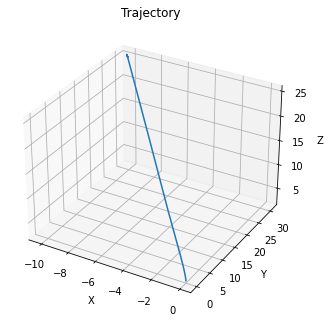

In [28]:
# Attaching 3D axis to the figure
fig3 = plt.figure(num = 3, figsize=(plt.figaspect(1)))
ax = Axes3D(fig3)

x = data['x'][:,9]
y = data['x'][:,10]
z = data['x'][:,11]
data_plot = np.array([x,y,z])

line = ax.plot(x, y, z)[0]

# Setting the axes properties
# ax.set_xlim3d([-50, 50])
# ax.set_ylim3d([-50, 50])
# ax.set_zlim3d([0, 100])

ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_zlabel('Z')

ax.set_title('Trajectory')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig3, update_lines, frames = x.size, fargs=(data_plot, line),
                            interval=50, blit=False)
line_ani.save('./flight.gif', writer='pillow', fps=60)

plt.show()

In [ ]:
def objective(eqs, x_vect, u_vect, p):
    return ca.dot(u_vect, u_vect)

def constraint(eqs, x_vect, u_vect, p):
    uf = u_vect[-1]
    xf = x_vect[:, -1]
    #x_dot = eqs['rhs'](xf, uf, p)
    distance = np.linalg.norm(xf[9:12]-par.endpoint)
    C_bn = euler_to_dcm(xf[6:9])
    velocity = np.linalg.norm(ca.mtimes(C_bn,xf[3:6]))
    return ca.vertcat(
        distance,  # be at 10 m altitude
        velocity,  # don't change altitude
    )
    
def optimize_trajectory(eqs, x0, p, t0, tf, h):
    # symbolic integration
    x = x0
    
    t_vect = par.time
    n = len(t_vect)
    u_vect = ca.SX.sym('u', n,4)
    x_vect = x0

    for t, u in zip(t_vect, ca.vertsplit(u_vect,1)):
        # res = scipy.integrate.solve_ivp(
        #     fun=lambda t, x: np.array(eqs['rhs'](x, u, p)).reshape(-1),
        #     t_span=[t, t+h], t_eval=[t+h], y0=x0
        # )
        # x = res['y']
        x = rk4(lambda t, x: eqs['rhs'](x, u, p), t, x, h)
        x_vect = ca.horzcat(x_vect, x)
    # NLP declaration
    nlp = {'x':u_vect,'f':objective(eqs, x, u_vect, p),'g':constraint(eqs, x_vect , u_vect, p)}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    n_g = 1
    res = S(x0=np.zeros(n),
            lbg=np.zeros(n_g), ubg=np.zeros(n_g),
            lbx=-10*np.ones(n), ubx=10*np.ones(n)
           )
    stats = S.stats()
    print(stats['return_status'])
    u_opt = res['x']
    return t_vect, u_opt, x

def simulate(eqs, x0, p, t_vect, u_vect):
    data = {
        't': [t_vect[0]],
        'x': [np.reshape(x0, -1)],
        'u': [u_vect[0]]
    }
    x = x0
    h = t_vect[1] - t_vect[0] # assumes equally spaced
    for t, u in zip(t_vect, u_vect):
        x = rk4(lambda t, x: eqs['rhs'](x, u, p), t, x, h)
        data['t'].append(t)
        data['u'].append(u)
        data['x'].append(np.reshape(x, -1))
    for k in data.keys():
        data[k] = np.array(data[k], dtype=float)
    return data

p = par.p
eqs = derive_equations()
x0 = [0] * 12
x0[9:12] = par.startpoint

t_vect, u_opt, x = optimize_trajectory(eqs, x0=x0, p=p, t0=0, tf=par.arrive_time, h=0.1)
data = simulate(eqs, x0, p, t_vect, u_opt)

plt.figure()
plt.plot(data['t'], data['x'][:, ], label='x')
plt.plot(data['t'], data['x'][:, 1], label='z')
plt.plot(data['t'], data['u'], label='omega')
plt.xlabel('t, sec')
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(data['x'][:, 0], data['x'][:, 1])
plt.xlabel('x')
plt.ylabel('z')
plt.grid(True)
plt.title('trajectory [side]')


In [9]:
np.arange?


Docstring:
arange([start,] stop[, step,], dtype=None)

Return evenly spaced values within a given interval.

Values are generated within the half-open interval ``[start, stop)``
(in other words, the interval including `start` but excluding `stop`).
For integer arguments the function is equivalent to the Python built-in
`range` function, but returns an ndarray rather than a list.

When using a non-integer step, such as 0.1, the results will often not
be consistent.  It is better to use `numpy.linspace` for these cases.

Parameters
----------
start : number, optional
    Start of interval.  The interval includes this value.  The default
    start value is 0.
stop : number
    End of interval.  The interval does not include this value, except
    in some cases where `step` is not an integer and floating point
    round-off affects the length of `out`.
step : number, optional
    Spacing between values.  For any output `out`, this is the distance
    between two adjacent values, ``out[i+1]